In [1]:
# Import the libraries we will need
import pandas as pd
import numpy as np

import findspark
findspark.init()

from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import *

# create the Spark Session
spark = SparkSession.builder.appName("Q2").getOrCreate()

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51872)
Traceback (most recent call last):
  File "c:\Users\Wenhao\miniconda3\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\Users\Wenhao\miniconda3\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "c:\Users\Wenhao\miniconda3\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\Users\Wenhao\miniconda3\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\accumulators.py", line 295, in handle
    poll(accum_updates)
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\accumulators.

In [2]:
data = spark.read.csv("hw2-bundle/hw2-bundle/kmeans/data/data.txt").toDF("observation")
data = data.withColumn("observation", F.split(F.col("observation"), " ").cast("array<float>"))
data = data.withColumn("obs_index", F.monotonically_increasing_id())
window = Window.orderBy(F.col("obs_index"))
data = data.withColumn("obs_index", F.row_number().over(window) - 1)

init_C_random = spark.read.csv("hw2-bundle/hw2-bundle/kmeans/data/c1.txt").toDF("centroid")
init_C_random = init_C_random.withColumn("centroid", F.split(F.col("centroid"), " ").cast("array<float>"))
init_C_random = init_C_random.withColumn("c_index", F.monotonically_increasing_id())
window = Window.orderBy(F.col("c_index"))
init_C_random = init_C_random.withColumn("c_index", F.row_number().over(window) - 1)

init_C_far = spark.read.csv("hw2-bundle/hw2-bundle/kmeans/data/c2.txt").toDF("centroid")
init_C_far = init_C_far.withColumn("centroid", F.split(F.col("centroid"), " ").cast("array<float>"))
init_C_far = init_C_far.withColumn("c_index", F.monotonically_increasing_id())
window = Window.orderBy(F.col("c_index"))
init_C_far = init_C_far.withColumn("c_index", F.row_number().over(window) - 1)

In [3]:
data.show(5)

+--------------------+---------+
|         observation|obs_index|
+--------------------+---------+
|[0.0, 0.64, 0.64,...|        0|
|[0.21, 0.28, 0.5,...|        1|
|[0.06, 0.0, 0.71,...|        2|
|[0.0, 0.0, 0.0, 0...|        3|
|[0.0, 0.0, 0.0, 0...|        4|
+--------------------+---------+
only showing top 5 rows



In [4]:
init_C_random.show(10)

+--------------------+-------+
|            centroid|c_index|
+--------------------+-------+
|[0.0, 0.64, 0.64,...|      0|
|[0.21, 0.28, 0.5,...|      1|
|[0.06, 0.0, 0.71,...|      2|
|[0.0, 0.0, 0.0, 0...|      3|
|[0.0, 0.0, 0.0, 0...|      4|
|[0.0, 0.0, 0.0, 0...|      5|
|[0.0, 0.0, 0.0, 0...|      6|
|[0.0, 0.0, 0.0, 0...|      7|
|[0.15, 0.0, 0.46,...|      8|
|[0.06, 0.12, 0.77...|      9|
+--------------------+-------+



In [5]:
def k_means(observation, initial_centroids, max_iter):
    def comb(x, y):
        if isinstance(x, list) & isinstance(y, list):
            return x + y
        elif isinstance(x, list):
            return x + [y]
        elif isinstance(y, list):
            return [x] + y
        else:
            return [x] + [y]
    
    def l2_distance(x, y):
        return float(np.linalg.norm(np.array(x) - np.array(y), ord=2) ** 2)
    l2_distance_udf = F.udf(l2_distance, FloatType())

    cost = np.zeros(max_iter + 1)

    # iteration 0 (initialization)
    new_partitions = observation.crossJoin(initial_centroids)
    new_partitions = new_partitions.withColumn("obs_to_c_dist", l2_distance_udf(F.col("observation"), F.col("centroid")))

    window = Window.partitionBy("obs_index")
    new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
    new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                        ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

    new_centroids = new_partitions.rdd.map(lambda row: (row["c_index"], row["observation"]))
    new_centroids = new_centroids.reduceByKey(lambda x, y: [comb(x[i], y[i]) for i in range(len(x))])
    new_centroids = spark.createDataFrame(new_centroids).toDF("c_index", "centroid")
    new_centroids = new_centroids.withColumn("centroid", 
                                                (F.udf(lambda x: np.array(x).mean(axis=1).tolist(), "array<float>"))(F.col("centroid")))

    cost[0] = np.sum(new_partitions.select("obs_to_c_dist").rdd.flatMap(lambda x: x).collect())
    print(f"At iteration 0, the cost is {cost[0]}.")

    # rest iterations
    for t in np.arange(1, max_iter + 1):
        new_partitions = observation.crossJoin(new_centroids)
        new_partitions = new_partitions.withColumn("obs_to_c_dist", l2_distance_udf(F.col("observation"), F.col("centroid")))

        window = Window.partitionBy("obs_index")
        new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
        new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                            ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

        # new_centroids = new_partitions.rdd.map(lambda row: (row.c_index, row.observation))
        # new_centroids = new_centroids.reduceByKey(lambda x, y: (np.array(x) + np.array(y)).tolist())
        # new_centroids = new_centroids.toDF().withColumnsRenamed({"_1": "c_index", "_2": "centroid"})
        # new_centroids = new_centroids.join(new_partitions.groupBy("c_index").count(), on="c_index", how="inner")
        # new_centroids = new_centroids.withColumn("centroid", (F.udf(lambda x, y: (np.array(x) / y).tolist(), "array<float>"))(F.col("centroid"), F.col("count")))
        # new_centroids = new_centroids.drop("count").sort("c_index")
        new_centroids = new_partitions.rdd.map(lambda row: (row["c_index"], row["observation"]))
        new_centroids = new_centroids.reduceByKey(lambda x, y: [comb(x[i], y[i]) for i in range(len(x))])
        new_centroids = spark.createDataFrame(new_centroids).toDF("c_index", "centroid")
        new_centroids = new_centroids.withColumn("centroid", 
                                                 (F.udf(lambda x: np.array(x).mean(axis=1).tolist(), "array<float>"))(F.col("centroid")))

        cost[t] = np.sum(new_partitions.select("obs_to_c_dist").rdd.flatMap(lambda x: x).collect())

        print(f"At iteration {t}, the cost is {cost[t]}.")

        new_centroids = new_centroids.collect()
        new_centroids = spark.createDataFrame(data=new_centroids)
    
    return cost, new_centroids.collect()

In [10]:
def k_medians(observation, initial_centroids, max_iter):
    def comb(x, y):
        if isinstance(x, list) & isinstance(y, list):
            return x + y
        elif isinstance(x, list):
            return x + [y]
        elif isinstance(y, list):
            return [x] + y
        else:
            return [x] + [y]
    
    def l1_distance(x, y):
        return float(np.linalg.norm(np.array(x) - np.array(y), ord=1))
    l1_distance_udf = F.udf(l1_distance, FloatType())

    cost = np.zeros(max_iter + 1)

    # iteration 0 (initialization)
    new_partitions = observation.crossJoin(initial_centroids)
    new_partitions = new_partitions.withColumn("obs_to_c_dist", l1_distance_udf(F.col("observation"), F.col("centroid")))

    window = Window.partitionBy("obs_index")
    new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
    new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                        ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

    new_centroids = new_partitions.rdd.map(lambda row: (row["c_index"], row["observation"]))
    new_centroids = new_centroids.reduceByKey(lambda x, y: [comb(x[i], y[i]) for i in range(len(x))])
    new_centroids = spark.createDataFrame(new_centroids).toDF("c_index", "centroid")
    new_centroids = new_centroids.withColumn("centroid", 
                                                (F.udf(lambda x: np.median(np.array(x), axis=1).tolist(), "array<float>"))(F.col("centroid")))
    new_centroids = new_centroids.collect()
    new_centroids = spark.createDataFrame(data=new_centroids)

    cost[0] = np.sum(new_partitions.select("obs_to_c_dist").rdd.flatMap(lambda x: x).collect())
    print(f"At iteration 0, the cost is {cost[0]}.")

    # rest iterations
    for t in np.arange(1, max_iter + 1):
        new_partitions = observation.crossJoin(new_centroids)
        new_partitions = new_partitions.withColumn("obs_to_c_dist", l1_distance_udf(F.col("observation"), F.col("centroid")))

        window = Window.partitionBy("obs_index")
        new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
        new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                            ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

        # new_centroids = new_partitions.rdd.map(lambda row: (row.c_index, row.observation))
        # new_centroids = new_centroids.reduceByKey(lambda x, y: (np.array(x) + np.array(y)).tolist())
        # new_centroids = new_centroids.toDF().withColumnsRenamed({"_1": "c_index", "_2": "centroid"})
        # new_centroids = new_centroids.join(new_partitions.groupBy("c_index").count(), on="c_index", how="inner")
        # new_centroids = new_centroids.withColumn("centroid", (F.udf(lambda x, y: (np.array(x) / y).tolist(), "array<float>"))(F.col("centroid"), F.col("count")))
        # new_centroids = new_centroids.drop("count").sort("c_index")
        new_centroids = new_partitions.rdd.map(lambda row: (row["c_index"], row["observation"]))
        new_centroids = new_centroids.reduceByKey(lambda x, y: [comb(x[i], y[i]) for i in range(len(x))])
        new_centroids = spark.createDataFrame(new_centroids).toDF("c_index", "centroid")
        new_centroids = new_centroids.withColumn("centroid", 
                                                 (F.udf(lambda x: np.median(np.array(x), axis=1).tolist(), "array<float>"))(F.col("centroid")))

        cost[t] = np.sum(new_partitions.select("obs_to_c_dist").rdd.flatMap(lambda x: x).collect())

        print(f"At iteration {t}, the cost is {cost[t]}.")

        new_centroids = new_centroids.collect()
        new_centroids = spark.createDataFrame(data=new_centroids)
    
    return cost, new_centroids.collect()

In [88]:
random_init_k_means_result = k_means(data, init_C_random, 20)

At iteration 0, the cost is 623747853.501003.
At iteration 1, the cost is 509851311.6232786.
At iteration 2, the cost is 485474455.838027.
At iteration 3, the cost is 463988317.16985035.
At iteration 4, the cost is 460962508.4620385.
At iteration 5, the cost is 460535298.3988676.
At iteration 6, the cost is 460318802.282403.


In [6]:
far_init_k_means_result = k_means(data, init_C_far, 20)

At iteration 0, the cost is 438747790.54135436.
+-------+--------------------+
|c_index|            centroid|
+-------+--------------------+
|      0|[0.098676704, 0.2...|
|      6|[0.27494118, 0.18...|
|      7|[0.17684211, 0.19...|
|      8|[0.45499998, 0.29...|
|      5|[0.195, 0.5, 0.4,...|
+-------+--------------------+
only showing top 5 rows



In [78]:
random_init_k_medians_result = k_medians(data, init_C_random, 20)

At iteration 0, the cost is 566777.1785924435.
At iteration 1, the cost is 466556.7499637604.
At iteration 2, the cost is 416670.8689211607.
At iteration 3, the cost is 414374.3965450525.
At iteration 4, the cost is 413445.0770753622.
At iteration 5, the cost is 412557.9209035635.
At iteration 6, the cost is 411171.6701442003.
At iteration 7, the cost is 410491.0217539072.
At iteration 8, the cost is 408960.535209775.
At iteration 9, the cost is 407911.74564802647.
At iteration 10, the cost is 407341.54387128353.
At iteration 11, the cost is 406677.8764721155.
At iteration 12, the cost is 406383.77173793316.
At iteration 13, the cost is 406226.81864106655.
At iteration 14, the cost is 406145.80651319027.
At iteration 15, the cost is 406059.7921952009.
At iteration 16, the cost is 406014.32916772366.
At iteration 17, the cost is 406002.6612328291.
At iteration 18, the cost is 405988.66998898983.
At iteration 19, the cost is 405973.0633867979.
At iteration 20, the cost is 405908.54271066

In [11]:
far_init_k_medians_result = k_medians(data, init_C_far, 20)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Wenhao\AppData\Local\Temp\ipykernel_4492\4201321219.py", line 1, in <module>
    far_init_k_medians_result = k_medians(data, init_C_far, 20)
  File "C:\Users\Wenhao\AppData\Local\Temp\ipykernel_4492\926234775.py", line 32, in k_medians
    new_centroids = new_centroids.collect()
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\sql\dataframe.py", line 1261, in collect
    sock_info = self._jdf.collectToPython()
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\py4j\java_gateway.py", line 1322, in __call__
    return_value = get_return_value(
  File "c:\Users\Wenhao\miniconda3\lib\site-packages\pyspark\errors\exceptions\captured.py", line 185, in deco
    raise converted from None
pyspark.errors.exceptions.captured.PythonException: 
  An exception was thrown f

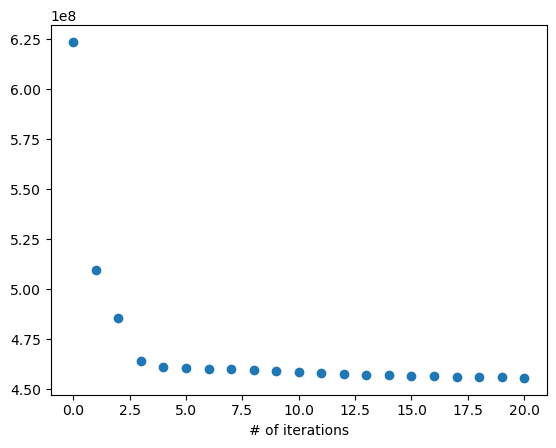

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(np.arange(0, 21), random_init_l2_distance_result[0])
ax.set_xlabel("# of iterations")
plt.show()

In [6]:
new_partitions = data.crossJoin(init_C_random)
new_partitions = new_partitions.withColumn("obs_to_c_dist", l2_distance_udf(F.col("observation"), F.col("centroid")))

window = Window.partitionBy("obs_index")
new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                    ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

# new_centroids = new_partitions.rdd.map(lambda row: (row.c_index, row.observation))
# new_centroids = new_centroids.reduceByKey(lambda x, y: (np.array(x) + np.array(y)).tolist())
# new_centroids = new_centroids.toDF().withColumnsRenamed({"_1": "c_index", "_2": "centroid"})
# new_centroids = new_centroids.join(new_partitions.groupBy("c_index").count(), on="c_index", how="inner")
# new_centroids = new_centroids.withColumn("centroid", (F.udf(lambda x, y: (np.array(x) / y).tolist(), "array<float>"))(F.col("centroid"), F.col("count")))
# new_centroids = new_centroids.drop("count").sort("c_index")


In [7]:
new_partitions.show(5)

+--------------------+---------+--------------------+-------+-------------+
|         observation|obs_index|            centroid|c_index|obs_to_c_dist|
+--------------------+---------+--------------------+-------+-------------+
|[0.0, 0.64, 0.64,...|        0|[0.0, 0.64, 0.64,...|      0|          0.0|
|[0.21, 0.28, 0.5,...|        1|[0.21, 0.28, 0.5,...|      1|          0.0|
|[0.06, 0.0, 0.71,...|        2|[0.06, 0.0, 0.71,...|      2|          0.0|
|[0.0, 0.0, 0.0, 0...|        3|[0.0, 0.0, 0.0, 0...|      3|          0.0|
|[0.0, 0.0, 0.0, 0...|        4|[0.0, 0.0, 0.0, 0...|      4|          0.0|
+--------------------+---------+--------------------+-------+-------------+
only showing top 5 rows



In [65]:
new_centroids = new_partitions.rdd.map(lambda row: (row.c_index, row.observation))

In [66]:
def comb(x, y):
    if isinstance(x, list) & isinstance(y, list):
        return x + y
    elif isinstance(x, list):
        return x + [y]
    elif isinstance(y, list):
        return [x] + y
    else:
        return [x] + [y]

In [67]:
new_centroids = new_centroids.reduceByKey(lambda x, y: [comb(x[i], y[i]) for i in range(len(x))])

In [68]:
new_centroids = spark.createDataFrame(new_centroids).toDF("c_index", "centroid")

In [69]:
new_centroids = new_centroids.withColumn("centroid", (F.udf(lambda x: np.array(x).mean(axis=1).tolist(), "array<float>"))(F.col("centroid")))

In [70]:
new_centroids.show(12)

+-------+--------------------+
|c_index|            centroid|
+-------+--------------------+
|      0|[0.11368687, 0.13...|
|      1|[0.10509677, 0.13...|
|      2|[0.2707619, 0.182...|
|      3|[0.11061728, 0.17...|
|      4|[0.060365852, 0.1...|
|      5|[0.119798996, 0.0...|
|      6|[0.117189266, 0.1...|
|      7|[0.06644317, 0.38...|
|      8|[0.22782257, 0.25...|
|      9|[0.14741258, 0.15...|
+-------+--------------------+



In [62]:
np.array(centroid_0[0][1]).mean(axis=1).tolist()

[0.11368686887075002,
 0.13171717205934652,
 0.3259595957669345,
 0.21760942804492284,
 0.4035858599475337,
 0.1214814816447922,
 0.19702020314481322,
 0.1381313128001762,
 0.1407912455825292,
 0.28823232358816997,
 0.09543771077235941,
 0.5731649815923336,
 0.1147474750550307,
 0.029528619865777116,
 0.04464646412517487,
 0.2894949491327058,
 0.2721212116361718,
 0.23375420795082544,
 1.718265993702492,
 0.15373737274697333,
 0.968838383076769,
 0.4774579149153497,
 0.17473064036255934,
 0.11134680115965882,
 0.49267676808504446,
 0.18279461297974844,
 0.08250841714115656,
 0.05552188520278995,
 0.039242424271524155,
 0.04483164976090694,
 0.03855218843679235,
 0.020488215717000994,
 0.05511784533458928,
 0.021397306637129798,
 0.05045454527693565,
 0.06893939398831189,
 0.14355218882111187,
 0.012693602767355915,
 0.03725589242346761,
 0.07390572238550443,
 0.02055555521839797,
 0.03533670041860655,
 0.03255892249595637,
 0.025471380551154364,
 0.12333333306641692,
 0.122441077645654